In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import os
import zipfile
import math
import kaggle
import shutil
import glob
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from PIL import Image

2024-03-19 21:48:18.218060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [ ]:
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

In [ ]:
import zipfile
with zipfile.ZipFile('brian-tumor-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()


# Data Splitting for Training, Validation and Testing

- ```train``` : Directory which will contain the training images (70% of data)
- ```val``` : Directory which will contain  the validation images (15% of data)
- ```test``` : Directory which will contain the testing images (15% of data)

In [ ]:
from creating_data_directories import create_data_directory

In [ ]:
create_data_directory('data', "Brain Tumor Data Set/Brain Tumor Data Set", "test", 0.15)
print(f"The test directory has been created with {len(os.listdir('data/test'))} subdirectories.")
create_data_directory('data', "Brain Tumor Data Set/Brain Tumor Data Set", "val", 0.15)
print(f"The val directory has been created with {len(os.listdir('data/val'))} subdirectories.")
create_data_directory('data',"Brain Tumor Data Set/Brain Tumor Data Set", "train")
print(f"The train directory has been created with {len(os.listdir('data/train'))} subdirectories.")

## Data Directories Successfully Created

# Building the Model

## Importing the required libraries and packages

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img,ImageDataGenerator

### Building the CNN model

In [25]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3),activation="relu",input_shape=(224,224,3), padding='same'))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1,activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 222, 222, 32)      4640      
                                                                 
 batch_normalization_3 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_4 (Bat  (None, 109, 109, 64)     

In [27]:
model.compile(optimizer="adam",loss=keras.losses.binary_crossentropy)

## Preparing data from Data Generators

In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [28]:
def preprocessing_images(path):
    """
    This function preprocesses the images in the given path.
    :param path: The path of the images.
    :return: The preprocessed images.
    """
    image_data = ImageDataGenerator(
        zoom_range=0.2,
        rescale=1./255,
        horizontal_flip=True
    )
    
    images = image_data.flow_from_directory(
        directory=path,
        target_size=(224,224),
        class_mode="binary",
        shuffle=True,
        classes=["Brain Tumor","Healthy"]
    )
    
    return images

In [29]:
# train_data_generator = image_dataset_from_directory(
#     directory="data/train",
#     labels="inferred",
#     class_names=["Brain Tumor","Healthy"],
#     color_mode="rgb",
#     image_size=(224,224),
#     shuffle=True,
# )
# 
# test_data_generator = image_dataset_from_directory(
#     directory="data/test",
#     labels="inferred",
#     class_names=["Brain Tumor","Healthy"],
#     color_mode="rgb",
#     image_size=(224,224),
#     shuffle=True,
# )
# 
# val_data_generator = image_dataset_from_directory(
#     directory="data/val",
#     labels="inferred",
#     class_names=["Brain Tumor","Healthy"],
#     color_mode="rgb",
#     image_size=(224,224),
#     shuffle=True,
# )

train_data = preprocessing_images("data/train")
test_data = preprocessing_images("data/test")
val_data = preprocessing_images("data/val")

Found 3325 images belonging to 2 classes.
Found 689 images belonging to 2 classes.
Found 586 images belonging to 2 classes.


## Early Stopping

We shall ask keras to stop the iterations early on if it does not find
any improvement in subsequent epochs

In [30]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ProgbarLogger, LearningRateScheduler

In [31]:
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=15,
    verbose=1,
    start_from_epoch=50,
    mode = 'min'
)

modelcheckpoint = ModelCheckpoint(
    filepath="final_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

logger = CSVLogger(
    filename="performance.csv",
    append=True
)

pbloader = ProgbarLogger()

In [32]:
callbacks = [earlystopping,modelcheckpoint,logger,pbloader]

In [ ]:
# Training the model
history = model.fit(train_data,steps_per_epoch=8,epochs=50,verbose=1,validation_data=val_data,validation_steps=16,callbacks=callbacks)

Epoch 1/50
      0/Unknown - 26s 0s/sample - loss: 8.0045
Epoch 1: val_loss improved from inf to 1.10090, saving model to final_model.keras
8/8 [==============================] - 42s 5s/sample - loss: 8.0045 - val_loss: 1.1009
Epoch 2/50
0/8 [..............................] - ETA: 0s - loss: 1.8427
Epoch 2: val_loss did not improve from 1.10090
8/8 [==============================] - 34s 4s/sample - loss: 1.8427 - val_loss: 2.3003
Epoch 3/50
0/8 [..............................] - ETA: 0s - loss: 0.9755
Epoch 3: val_loss did not improve from 1.10090
8/8 [==============================] - 34s 4s/sample - loss: 0.9755 - val_loss: 5.3793
Epoch 4/50
0/8 [..............................] - ETA: 0s - loss: 0.7741
Epoch 4: val_loss did not improve from 1.10090
8/8 [==============================] - 36s 4s/sample - loss: 0.7741 - val_loss: 8.5814
Epoch 5/50
0/8 [..............................] - ETA: 0s - loss: 0.6914
Epoch 5: val_loss did not improve from 1.10090
8/8 [===========================

<Axes: >

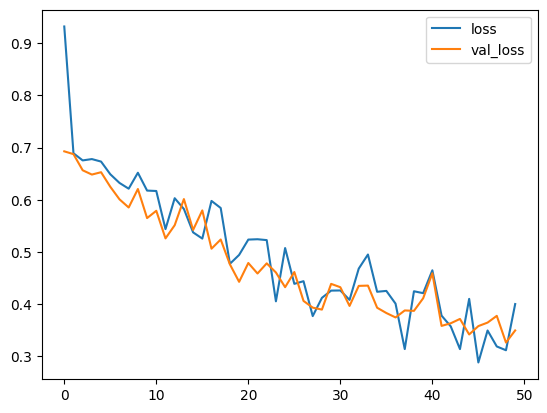

In [17]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [ ]:
model.save("final-model.keras")